# Recommendation Systems
## Assignment 1: Matrix Factorization & Evaluation

**By:**  
Group 16

Alexander Tsvetkov 322155516 

Ofer Inbar 033856402
<br><br>

**The goal of this assignment is to:**
- Understand the details of matrix factorization algorithm
- Practice recommender system training and evaluation.

**Instructions:**
- Students will form teams of two people each, and submit a single homework for each team.
- The same score for the homework will be given to each member of the team.
- Your solution in the form of an Jupyter notebook file (with extension ipynb).
- Images/Graphs/Tables should be submitted inside the notebook.
- The notebook should be runnable and properly documented. 
- Please answer all the questions and include all your code.
- Please use English language only.

**Submission:**
- Submission of the homework will be done via Moodle by uploading a Jupyter notbook.
- The homework needs to be entirely in English.
- The deadline for submission is on Moodle.

**Requirements:**  
- Python 3.6+ should be used.  
- You should implement the matrix factorization algorithm by yourself using only basic Python libraries (such as numpy).



<br><br><br><br>

**Grading:**
- Q1 - 0 points - Data exploration
- Q2 - 25 points - Evaluation metrics
- Q3 - 50 points - Models implementation and evaluation
  -  A. Popularity basline model: 10 points
  -  B. Explicit Matrix Factorization: 25 points
  -  C. Train & HyperParams Search: 5 points 
  -  D. Bias only model: 5 points
  -  E. Discussion: 5 points
- Q4 - 25 points - Similarity & Explainability 

`Total: 100`

**Prerequisites**

In [107]:
# !pip install --quiet zipfile36 pandas seaborn
%pip install --quiet zipfile36 pandas seaborn


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Python39\python.exe -m pip install --upgrade pip' command.


In [108]:
# general
import time
import random
import zipfile
import requests
import warnings

# ml
import numpy as np
import scipy as sp
import pandas as pd

# visual
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tck

# metrics - do not use these metrics, but you can use them to check your work
from sklearn.metrics import mean_squared_error,ndcg_score 

# notebook
from IPython.display import FileLink, display

**Hide Warnings**

In [109]:
warnings.filterwarnings('ignore')

**Disable Autoscrolling**

In [110]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

**Set Random Seed**

In [111]:
random.seed(123)

# Question 1:

## Data exploration 

Download the MovieLens 100K rating dataset.   
Calculate the dataset sparsity, distribution of number of ratings as well as the average rating value per user\item.  
Include additional exploration you find relevant to questions 2 and 3.  
Discuss your insights and possible challenges related to the prediction task described in question 2.  

In [112]:
url = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
zip_name = 'ml-100k.zip'
data_dir = 'ml-100k/'

r = requests.get(url, allow_redirects=True)
open(zip_name, 'wb').write(r.content)

with zipfile.ZipFile(zip_name,"r") as zip_ref:
    zip_ref.extractall()

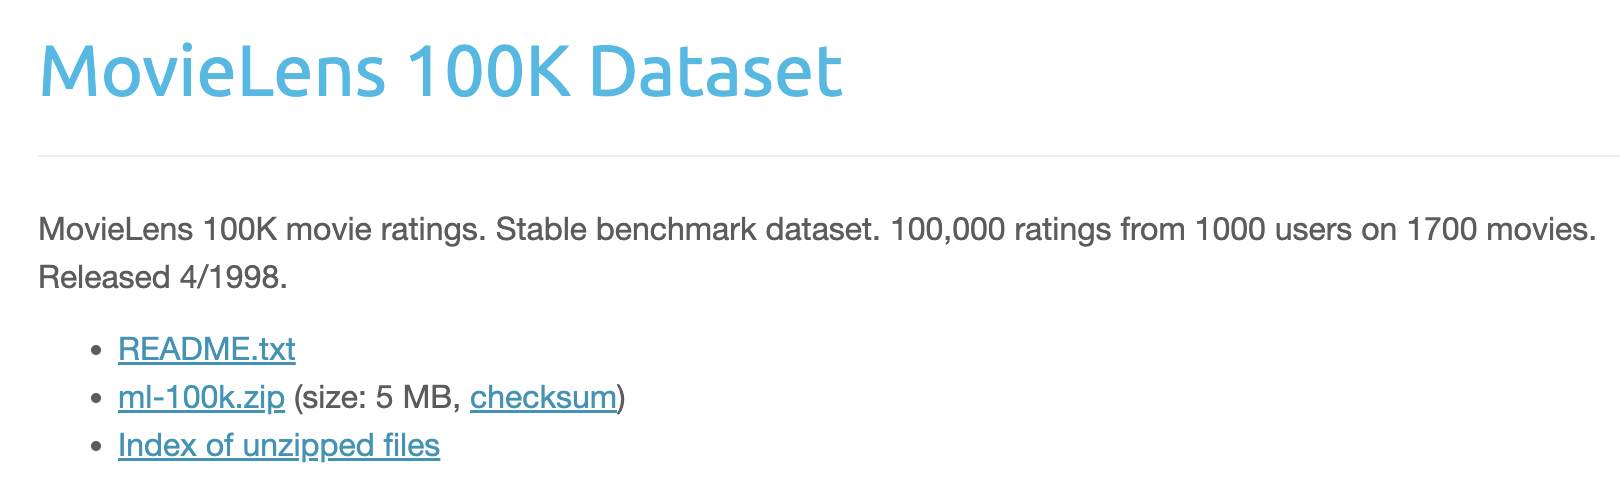

**Columns Names**

In [113]:
cols_data = ['user_id','item_id','rating','timestamp']
cols_user = ['user_id','age','gender','occupation','zip code']
cols_item = ['movie id','movie_title','release_date','video_release_date','IMDb_URL','unknown','Action','Adventure','Animation',
             'Childrens','Comedy','Crime','Documentary','Drama','Fantasy','Film_Noir','Horror','Musical','Mystery','Romance',
             'Sci_Fi','Thriller','War','Western']

**Read users data file**

In [114]:
df_users = pd.read_csv(data_dir + 'u.user',delimiter='|', header=None,names=cols_user)
df_users.shape

(943, 5)

**Read items(movies) data file**

In [115]:
df_items = pd.read_csv(data_dir + 'u.item',delimiter='|', header=None,names=cols_item,encoding="ISO-8859-1")
df_items.shape

(1682, 24)

**Read rating data file**

In [116]:
df_ratings = pd.read_csv(data_dir + 'u.data',delimiter='\t', header=None,names=cols_data)
df_ratings.shape

(100000, 4)

Making sure shapes are matching the info data file

In [117]:
open(data_dir + 'u.info').readlines()

['943 users\n', '1682 items\n', '100000 ratings\n']

**Matrix:**

In [118]:
ratings = df_ratings.pivot(index = 'user_id', columns ='item_id', values = 'rating').fillna(0)
ratings.head()

item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<br><br><br><br>
**Explore ratings data:**

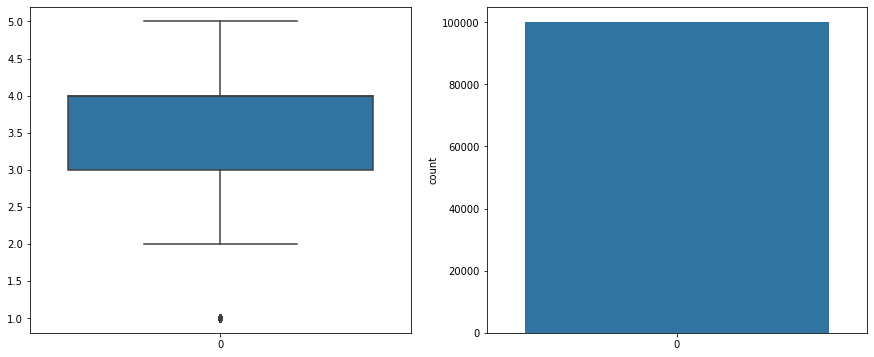

In [119]:
f, axes = plt.subplots(1, 2,figsize=(15,6))
sns.boxplot(df_ratings.rating,ax=axes[0])
sns.countplot(df_ratings.rating,ax=axes[1])
plt.show()

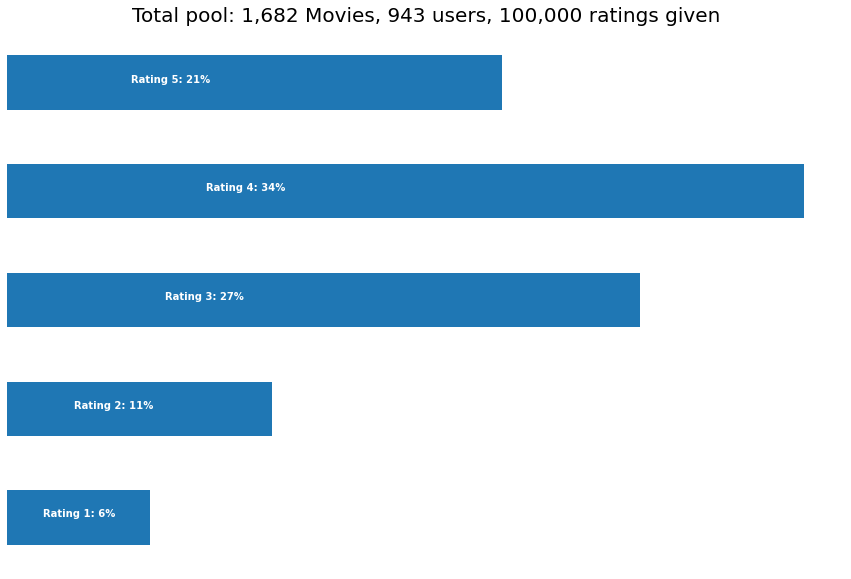

In [120]:
p = df_ratings.groupby('rating')['rating'].agg(['count'])
movie_count = df_ratings.item_id.nunique()
cust_count = df_ratings.user_id.nunique() 
rating_count = df_ratings.user_id.count()

ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} users, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

**Distribution of number of ratings per user\item**

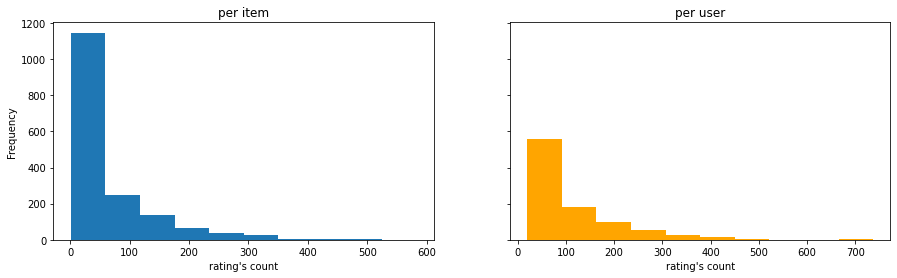

In [121]:
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(15, 4))

ratings.astype(bool).sum(axis=0).plot.hist(ax=ax[0])
ratings.astype(bool).sum(axis=1).plot.hist(ax=ax[1],color='orange')
ax[0].set_title('per item')
ax[1].set_title('per user')
ax[0].set_xlabel('rating\'s count')
ax[1].set_xlabel('rating\'s count');

**Distribution of average rating value  per user\item**

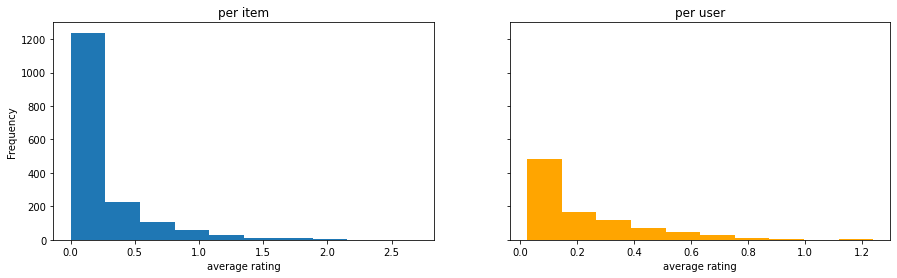

In [122]:
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(15, 4))

ratings.mean(axis=0).plot.hist(ax=ax[0])
ratings.mean(axis=1).plot.hist(ax=ax[1],color='orange')
ax[0].set_title('per item')
ax[1].set_title('per user')
ax[0].set_xlabel('average rating')
ax[1].set_xlabel('average rating');

**Movie ratings aggregated by user**

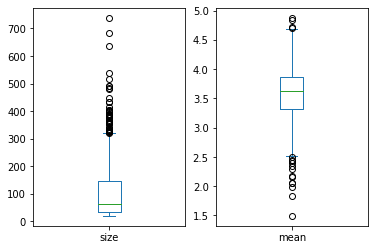

In [123]:
userRatingsAggr = df_ratings.groupby(['user_id']).agg({'rating': [np.size, np.mean]})
userRatingsAggr.reset_index(inplace=True)  # To reset multilevel (pivot-like) index
userRatingsAggr['rating'].plot(kind='box', subplots=True)
plt.show();

**Genres**

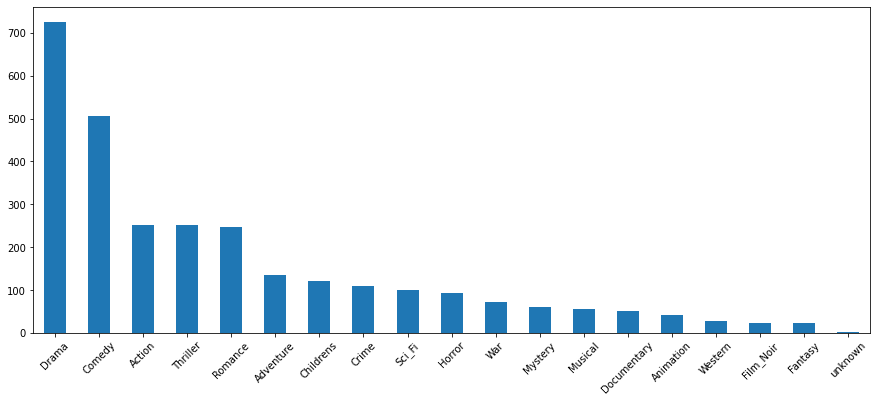

In [124]:
plt.figure(figsize=(15,6))
df_items.iloc[:,5:].sum().sort_values(ascending=False).plot.bar()
plt.xticks(rotation=45)
plt.show();

**Calculate the dataset sparsity:**

$$
Density  = \frac{\text{number of nonzero ratings in the matrix}}{\text{number of users}\times\text{number of items}} 
\quad \qquad
Sparsity = 1 - \frac{\text{number of nonzero ratings in the matrix}}{\text{number of users}\times\text{number of items}}
$$

In [125]:
matrix_sparsity =  round((1-np.count_nonzero(ratings)/ratings.size)*100,2)
print('Sparsity is equal to {}%'.format(str(matrix_sparsity)) )

Sparsity is equal to 93.7%


<br><br><br><br><br><br>

# Question 2:


## Evaluation Metrics

Please create a class to calculate the following metrics on two different dataset (df_true,df_pred):
- RMSE
- MRR
- nDCG

**Notes:**
- Please read this great blog post: 
<a href='https://medium.com/swlh/rank-aware-recsys-evaluation-metrics-5191bba16832'>MRR vs MAP vs NDCG: Rank-Aware Evaluation Metrics And When To Use Them </a>
- Please consider edge cases - NaN, Null, Zeros, out of bound, eval time, etc.
- You can work with Dataframe or with Numpy arrays(matrix)
- You may remove/add params to these functions
- Please use only pytonic code!

In [169]:
class my_metrics:
    @staticmethod
    def RMSE(df_true: np.ndarray, df_pred: np.ndarray, lower_bound=1, upper_bound=5) -> float:
        """ Root Mean Squared Error for all users """
        # Flatten both arrays
        df_true = df_true.flatten()
        df_pred = df_pred.flatten()

        return np.sqrt(np.mean((df_true[df_true.nonzero()] - df_pred[df_true.nonzero()]) ** 2))
    
    @staticmethod
    def MRR(df_true: np.ndarray, df_pred: np.ndarray, lower_bound=4, top_n=5) -> float:
        """ Mean Reciprocal Rank for all users """

        relevant_indices = np.count_nonzero(df_true, axis=1) > 0
        # Get true indices of temp
        relevant_users = np.argwhere(relevant_indices).flatten()
        scores = [
            my_metrics.MRR_for_user(df_true[i], df_pred[i], lower_bound, top_n)
            for i in relevant_users
        ]
        return np.mean(scores)

    # @staticmethod
    def MRR_for_user(user_true: np.ndarray, user_pred: np.ndarray, lower_bound=4, top_n=5) -> float:
        """ Computes MRR for a single user.
        Args:
            user_true: list of true ratings for a single user
            user_pred: list of predicted ratings for a single user
            lower_bound: lower bound of rating scale
            top_n: number of top items to consider
        Returns:
            MRR for a single user
        """
        relevant_user_true_ratings = user_true[user_true.nonzero()]
        user_pred = user_pred[user_true.nonzero()]
        # Get the indices of the top_n items in user pred ratings
        top_n_indices = np.argsort(user_pred)[::-1][:top_n]
        for key, value in enumerate(top_n_indices):
            if relevant_user_true_ratings[value] >= lower_bound:
                return 1 / (key + 1)
        # if there is no match, return 0
        return 0

    @staticmethod
    def NDCG(df_true: np.ndarray, df_pred: np.ndarray, top_n=5) -> float:
        """ Computes NDCG for all users """
        # Filter out users with no ratings
        relevant_indices = np.count_nonzero(df_true, axis=1) > 0
        relevant_users = np.argwhere(relevant_indices).flatten()
        scores = [
            my_metrics.NDCG_for_user(df_true[i], df_pred[i], top_n)
            for i in relevant_users
        ]
        return np.mean(scores)

    @staticmethod
    def NDCG_for_user(user_true: np.ndarray, user_pred: np.ndarray, top_n=5) -> float:
        """ Computes NDCG for a single user.
        Args:
            user_true: list of true ratings for a single user
            user_pred: list of predicted ratings for a single user
            lower_bound: lower bound of rating scale
            upper_bound: upper bound of rating scale
            top_n: number of top items to consider
        Returns:
            NDCG for a single user
        """
        # Get the indices of the top_n items in user pred ratings
        relevant_user_true_ratings = user_true[user_true.nonzero()]
        user_pred = user_pred[user_true.nonzero()]
        top_n_indices = np.argsort(user_pred)[::-1][:top_n]
        dcg = 0
        for key, value in enumerate(top_n_indices):
            dcg += relevant_user_true_ratings[value] / np.log2(key + 2)

        idcg = 0
        top_n_true_indices = np.argsort(relevant_user_true_ratings)[::-1][:top_n]
        # Remove indices of items that are not rated by the user
        top_n_true_indices = top_n_true_indices[relevant_user_true_ratings[top_n_true_indices] > 0]
        for key, value in enumerate(top_n_true_indices):
                idcg += relevant_user_true_ratings[value] / np.log2(key + 2)
        
        return dcg / idcg if idcg != 0 else 0

    @staticmethod
    def DCG(rel, n):
        # please implement the DCG formula
        pass

    @staticmethod
    def get_error(df_true: np.ndarray, df_pred: np.ndarray) -> dict:
        return {
            "RMSE": my_metrics.RMSE(
                df_true,
                df_pred,
            ),
            "MRR_5": my_metrics.MRR(df_true, df_pred, top_n=5),
            "MRR_10": my_metrics.MRR(df_true, df_pred, top_n=10),
            "NDCG_5": my_metrics.NDCG(df_true, df_pred, top_n=5),
            "NDCG_10": my_metrics.NDCG(df_true, df_pred, top_n=10),
        }


Checking your evaltuation metrics and performence:

In [163]:
# Convert to numpy array
ratings_as_array = ratings.to_numpy(copy=True)
%time my_metrics.get_error(ratings_as_array,ratings_as_array)

CPU times: total: 281 ms
Wall time: 243 ms


{'RMSE': 0.0,
 'MRR_5': 0.9991162955107812,
 'MRR_10': 0.9990359587390341,
 'NDCG_5': 1.0,
 'NDCG_10': 1.0}

# Question 3

### Models Implementation & Evaluation
Split the data to train and test.  
Implement explicit matrix factorization algorithm to predict the rating a user will provide to an item and recommendation of top N items.   

Use the RMSE, MRR and NDCG metrics (based on Q2 implementation) to evaluate your recommender system. For the MRR and NDCG metrics use cutoff value of 5. Items with a rating of 3 and above are considered as relevant.   

Produce a learning curve graph and a table which compares the results of the following algorithms: 
 - Bias only based model
 - Simple popularity based model
 - Different choices of the latent factor dimension regularization, learning rate. 



**Save final results**

In [128]:
final_results = pd.DataFrame(columns=['Method','Time','RMSE','MRR_5','MRR_10','NDCG_5','NDCG_10'])

**Choose fold**

In [129]:
df_folds = {i:
       {'train' : pd.read_csv('{}u{}.base'.format(data_dir,i), delimiter='\t', header=None, names=cols_data),
        'test'  : pd.read_csv('{}u{}.test'.format(data_dir,i), delimiter='\t', header=None, names=cols_data)
       } for i in range(1,6)} 

def fold2df(i):
    train = df_folds[i]['train'].pivot(index = 'user_id', columns ='item_id', values = 'rating').fillna(0)
    test  = df_folds[i]['test'].pivot(index = 'user_id', columns ='item_id', values = 'rating').fillna(0)
    return train,test 

def getfulldf(train_fold,test_fold):
    train = ratings.copy()
    train[:] = 0
    test = train.copy()
    
    train.loc[train_fold.index,train_fold.columns] = train_fold.values
    test.loc[test_fold.index,test_fold.columns] = test_fold.values
    return train,test

fold = 1
train,test = getfulldf(*fold2df(fold))

train.shape,test.shape

((943, 1682), (943, 1682))

### A. Popularity model

Recommend the most popular movies which have more than 10 ratings.

Use the RMSE, MRR and NDCG metrics to evaluate your recommender system.   
For the MRR and NDCG metrics use cutoff values of 5 and 10.   

In [130]:
class POP():

    def __init__(self,df_train,M=10):
    # df is the set to train on
    # N is the number of movies to recommend
    # M is the minimum votes required to be listed in the chart
        self.df_train = (
            df_train if isinstance(df_train, np.ndarray) else df_train.to_numpy(copy=True)
        )
        self.min_movie_ratings = M
        self.recommended = None
        self.fit_time = 0
        self.prediction = None 

        
    def fit(self):
        self.fit_time = 0
        # start timer
        start = time.time()
        # movieCount, movieSum = None, None
        movieCount = np.count_nonzero(self.df_train, axis=0)
        movieSum = np.sum(self.df_train, axis=0)
        movieMean = np.ones_like(self.df_train[0])
        rec = np.divide(movieSum,movieCount,where= (movieCount > self.min_movie_ratings))
        self.recommended= np.resize(rec, new_shape= self.df_train.shape)
        # stop timer
        self.fit_time = time.time() - start
        
        
    def predict(self,N=10):
        # return the top N movies
        self.prediction= None
        self.prediction= np.flip(np.argsort(self.recommended[0])[-(1 + N):-1] )
        return self.prediction

    def get_rmse(self, test):
        return my_metrics.RMSE(test, self.recommended)

    def get_mrr(self, test, k=5, threshold=4):
        return my_metrics.MRR(test, self.recommended, top_n=k, lower_bound=threshold)

    def get_ndcg(self, test, k=10):
        return my_metrics.NDCG(test, self.recommended, top_n=k)

    # this is just a quick checking function for you to use while debugging
    def predict_title(self):
        return df_items.set_index('movie id').loc[self.predict()-1]['movie_title']

Checking your model and performance:

In [131]:
model_pop= None
model_pop = POP(train)

# train model
%timeit model_pop.fit()
print(model_pop.predict_title())

8.09 ms ± 85.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
movie id
1185          In the Army Now (1994)
1247                Bad Girls (1994)
1170      Spanking the Monkey (1994)
1252    Contempt (Mépris, Le) (1963)
1164         Zeus and Roxanne (1997)
1516        Wedding Gift, The (1994)
1402        Ciao, Professore! (1993)
1152          In Love and War (1996)
1264          Nothing to Lose (1994)
712                   Tin Men (1987)
Name: movie_title, dtype: object


In [132]:
# create popularity model
model_pop= None
model_pop = POP(train)

# train model
%timeit model_pop.fit()
print(model_pop.predict_title())

final_results.loc[len(final_results)] = 'Popularity', model_pop.fit_time, model_pop.get_rmse(test.values), model_pop.get_mrr(test.values,k=5), model_pop.get_mrr(test.values,k=10), model_pop.get_ndcg(test.values,k=5), model_pop.get_ndcg(test.values,k=10)

# display
final_results

8.21 ms ± 124 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
movie id
1185          In the Army Now (1994)
1247                Bad Girls (1994)
1170      Spanking the Monkey (1994)
1252    Contempt (Mépris, Le) (1963)
1164         Zeus and Roxanne (1997)
1516        Wedding Gift, The (1994)
1402        Ciao, Professore! (1993)
1152          In Love and War (1996)
1264          Nothing to Lose (1994)
712                   Tin Men (1987)
Name: movie_title, dtype: object


,Method,Time,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10
0,Popularity,0.008003,1.308793,0.700399,0.702474,0.822597,0.856581


### B. Explicit Matrix Factorization

**Implement explicit matrix factorization algorithm to predict the rating a user will provide to an item and recommendation of top N items.**

Use the RMSE, MRR and NDCG metrics to evaluate your recommender system.   
For the MRR and NDCG metrics use cutoff values of 5 and 10.   

In [170]:
class MF:
    def __init__(self, df_train, n_factors=10, only_bias=False, batch_size=200):
        # convert to numpy array if not already
        self.df_train = (
            df_train if isinstance(df_train, np.ndarray) else df_train.to_numpy(copy=True)
        )
        self.batch_size = batch_size
        self.n_factors = n_factors
        self.only_bias = only_bias
        self.user_vectors = None
        self.item_vectors = None
        self.prediction = None
        self.gradient_user_vectors = None
        self.gradient_item_vectors = None
        # rows==users , cols==items
        self.n_rows, self.n_cols = df_train.shape

        # biases
        self.original_bias_global = np.sum(df_train) / np.count_nonzero(df_train)
        self.original_bias_rows = np.sum(df_train, axis=1) / np.count_nonzero(df_train, axis=1)
        self.original_bias_cols = np.sum(df_train, axis=0) / np.count_nonzero(df_train, axis=0)

        # "reset" initialization
        self.initialize_params()

    def initialize_params(self):
        if self.only_bias:
            pass
        else:
            self.user_vectors = np.random.normal(
                scale=1.0 / self.n_factors, size=(self.n_rows, self.n_factors)
            )
            self.item_vectors = np.random.normal(
                scale=1.0 / self.n_factors, size=(self.n_cols, self.n_factors)
            )

        # initialize bias
        self.bias_global = self.original_bias_global  # no need to learn it
        self.bias_rows = np.zeros(self.n_rows)
        self.bias_cols = np.zeros(self.n_cols)

    def fit(
        self,
        n_iterations=1,
        learning_rate=1e-1,
        regularization=1e-2,
        convergence=1e-5,
        error="RMSE",
        initialize_training=True,
        verbose=True,
        batch_size=200,
    ):

        self.n_iterations = n_iterations
        self.α = learning_rate
        self.λ = regularization
        self.ϵ = convergence
        self.error = error
        self.sample_row, self.sample_col = self.df_train.nonzero()
        self.n_samples = len(self.sample_row)

        if initialize_training:
            self.initialize_params()

        # please record your progress in history
        self.history = []

        # please record the training time in fit_time
        self.fit_time = 0
        # start timer
        start = time.time()

        # please use the class functions
        # for example(!) :
        if self.only_bias == False:
            self.prev_user_vectors = self.user_vectors.copy()
            self.prev_item_vectors = self.item_vectors.copy()
        self.prev_bias_rows = self.bias_rows.copy()
        self.prev_bias_cols = self.bias_cols.copy()
        self.prev_bias_global = self.bias_global
        for current_iteration in range(self.n_iterations):
            self.prediction = self.predict()
            self.history.append(self.calculate_error())

            # printing
            if verbose and current_iteration % 10 == 0:
                print("iteration: ", current_iteration, " total error:\n", self.history[-1])

            # convergence
            if current_iteration != 0 and self.converging():

                if verbose:
                    print("converged...")
                break

            # split data
            self.optim_GD()

        # stop timer
        self.fit_time = time.time() - start

    def calculate_error(self):
        if self.error == "RMSE":
            return self.get_rmse(self.df_train)
        elif self.error == "MRR":
            return self.get_mrr(self.df_train)
        elif self.error == "NDCG":
            return self.get_ndcg(self.df_train)
        else:
            raise ValueError("error type not supported")

    def converging(self):
        # Frobinius norm between previous and current user/item vectors
        if self.only_bias:
            return (
                np.linalg.norm(self.prev_bias_rows - self.bias_rows)
                + np.linalg.norm(self.prev_bias_cols - self.bias_cols)
                + np.linalg.norm(self.prev_bias_global - self.bias_global)
            ) < self.ϵ
        else:
            return (
                np.linalg.norm(self.prev_user_vectors - self.user_vectors)
                + np.linalg.norm(self.prev_item_vectors - self.item_vectors)
                + np.linalg.norm(self.prev_bias_rows - self.bias_rows)
                + np.linalg.norm(self.prev_bias_cols - self.bias_cols)
                + np.linalg.norm(self.prev_bias_global - self.bias_global)
            ) < self.ϵ


    def optim_GD(self):
        training_indices = np.arange(self.n_samples)
        np.random.shuffle(training_indices)
        user_index_history = []
        item_index_history = []
        e_history = []
        # Divide training_indices into batches of size batch_size

        training_indices_batches = np.array_split(training_indices, self.n_samples // self.batch_size)

        for batch in training_indices_batches:
                user_indices = self.sample_row[batch]
                item_indices = self.sample_col[batch]
                prediction = self.predict()
                e = self.df_train[user_indices, item_indices] - prediction[user_indices, item_indices]
                self.update_batch(user_indices, item_indices, e)




    def update_batch(self, user_index_history, item_index_history, e_history):
        self.bias_rows[user_index_history] += self.α * (e_history - self.λ * self.bias_rows[user_index_history]) / self.batch_size
        self.bias_cols[item_index_history] += self.α * (e_history - self.λ * self.bias_cols[item_index_history]) / self.batch_size
        if self.only_bias == False:
            self.user_vectors[user_index_history, :] += self.α * (
                e_history[:, np.newaxis] * self.item_vectors[item_index_history, :] - self.λ * self.user_vectors[user_index_history, :]
            ) / self.batch_size
            self.item_vectors[item_index_history, :] += self.α * (
                e_history[:, np.newaxis] * self.user_vectors[user_index_history, :] - self.λ * self.item_vectors[item_index_history, :]
            ) / self.batch_size

    def predict(self):
        if self.only_bias == False:
            predictions = self.user_vectors @ self.item_vectors.T
        else:
            predictions = np.zeros(self.df_train.shape)

        # Add biases
        predictions += self.bias_global
        predictions += self.bias_rows[:, np.newaxis]
        predictions += self.bias_cols[np.newaxis, :]

        return predictions

    def get_rmse(self, test):
        return my_metrics.RMSE(test, self.prediction)

    def get_mrr(self, test, k=5, threshold=4):
        return my_metrics.MRR(test, self.prediction, top_n=k, lower_bound=threshold)

    def get_ndcg(self, test, k=10):
        return my_metrics.NDCG(test, self.prediction, top_n=k)




Checking your model and performance:

In [172]:
# create MF model
model_mf = MF(train.values,n_factors=5,only_bias=False)

# train model
%time model_mf.fit(n_iterations=2,verbose=True,regularization=0.01,convergence=0.000001,learning_rate=0.001, initialize_training=True)

# record model results
temp_results = pd.DataFrame(columns=['Method','Time','RMSE','MRR_5','MRR_10','NDCG_5','NDCG_10'])
# Note That I'm sending test.values
temp_results.loc[len(final_results)] = 'MF', model_mf.fit_time, model_mf.get_rmse(test.values), model_mf.get_mrr(test.values,k=5), model_mf.get_mrr(test.values,k=10), model_mf.get_ndcg(test.values,k=5), model_mf.get_ndcg(test.values,k=10)

# display
pd.merge(temp_results, final_results, how='outer')

iteration:  0  total error:
 1.1218640022259172
iteration:  1  total error:
 1.119664791941913
iteration:  2  total error:
 1.1174932189423776
CPU times: total: 1min 26s
Wall time: 10.6 s


,Method,Time,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10
3,MF,10.597581,1.152794,0.741612,0.745599,0.77058,0.805963


In [135]:
from os import path
def isDFThere( dfName, path= ''):
    Path = os.path.isfile(f'{path}{dfName}.csv')
    print(f'found {dfName} at path : {Path}')
    if Path==True:
        df = pd.read_csv(f'{path}{dfName}.csv')
        return df
    else:
        return False

<br><br><br>

## C. Train & HyperParams Search 


**Different choices of the latent factor dimension, regularization, learning rate.**

and Find best hyperparameters


While running of these permutations:

    - n_iterations   = [20]     
    - convergence    = [1e-5]    
    - latent_factors = [5,10,20]    
    - regularization = [0.01,0.1,1]    
    - learning_rate  = [0.001,0.01,0.1]    



In [136]:
n_iterations   = [200, 500] # just one value due to computational power
convergence    = [1e-3]  
latent_factors = [10, 20, 5]
regularization = [0.1, 1, 0.01]
# learning_rate  = [0.001, 0.01, 0.1]
learning_rate  = [0.5, 0.05, 0.005]
batch_size     = [20, 100, 200, 400]
DFFileName= '500results'
# number of experiments:
if type(isDFThere(DFFileName)) == pd.core.frame.DataFrame:
    results = isDFThere(DFFileName)
else:
    results = pd.DataFrame(columns=['Latent_factors','Iterations','Learning_Rate','Regularization','BatchSize','Convergence','RMSE','MRR_5','MRR_10','NDCG_5','NDCG_10','History','Time'])
    n_experiments = len(n_iterations)*len(latent_factors)*len(learning_rate)*len(regularization)*len(convergence)*len(batch_size)
    i=0
    for n_iter in n_iterations:
        for lf in latent_factors:
            for lr in learning_rate:
                for reg in regularization:
                    for conv in convergence:
                        for bs in batch_size:
                            dic = {'Iterations':n_iter,'Latent_factors':lf,'Learning_Rate':lr,'Regularization':reg,'BatchSize':bs,'Convergence':conv}
                            # initialize model
                            mf = MF(train.values,n_factors=lf, only_bias=False)
                            # record training time
                            start = time.time()
                            # train MF
                            mf.fit(n_iterations=n_iter,verbose=True,learning_rate=lr,regularization=reg,convergence=conv, batch_size=bs)
                            dic['Time'] = time.time() - start
                            # eval model
                            # please use the model evaluation funcntions 
                            dic["RMSE"]    = mf.get_rmse(test.values)
                            dic["MRR_5"]   = mf.get_mrr(test.values,k=5)
                            dic["MRR_10"]  = mf.get_mrr(test.values,k=10)
                            dic["NDCG_5"]  = mf.get_ndcg(test.values,k=5)
                            dic["NDCG_10"] = mf.get_ndcg(test.values,k=10)
                            # record model history
                            dic['IterPerformed'] = len(mf.history) # number of iterations performed
                            i+=1
                            dic['History'] = mf.history # model 
                            # add experiment
                            print(f'Done with {i}/{n_experiments} experiments, RMSE {dic["RMSE"]} batch size {bs} latent factors {lf} learning rate {lr} regularization {reg} convergence {conv} iterations performed {len(mf.history)}')
                            results = results.append(dic,ignore_index=True)
                            results.to_csv(f'{DFFileName}.csv',index=False)
results.head(5)

found 500results at path : True
found 500results at path : True


,Latent_factors,Iterations,Learning_Rate,Regularization,BatchSize,Convergence,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10,History,Time,IterPerformed
0,10,200,0.5,0.10,20,0.001,3.341601,0.044963,0.054127,0.026890,0.030928,"[3.4465223238595657, 3.441663657068171, 3.4352...",953.034185,200
1,10,200,0.5,0.10,100,0.001,3.339057,0.042983,0.054283,0.025413,0.030019,"[3.446544066864325, 3.4422772042103156, 3.4356...",896.150068,200
2,10,200,0.5,1.00,20,0.001,3.387098,0.000212,0.006030,0.000575,0.006964,"[3.446529216537632, 3.4415685063365165, 3.4354...",895.523866,200
3,10,200,0.5,1.00,100,0.001,3.386234,0.003181,0.009424,0.002936,0.010293,"[3.4465473983583474, 3.441661088529265, 3.4360...",896.488292,200
4,10,200,0.5,0.01,20,0.001,3.324303,0.063856,0.074230,0.035177,0.037678,"[3.446533335992781, 3.4417292383606775, 3.4352...",903.963615,200


**Training history:**

**Focus on the top 3:**

In [137]:
results['RMSEFloat'] = results['RMSE'].astype(float)
nSmallestIdx= results['RMSEFloat'].nsmallest(3).index
results.loc[nSmallestIdx,:].head()

,Latent_factors,Iterations,Learning_Rate,Regularization,BatchSize,Convergence,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10,History,Time,IterPerformed,RMSEFloat
94,5,500,0.5,0.01,200,0.001,3.314466,0.028049,0.037327,0.014408,0.018851,"[3.4475839180769663, 3.442644870487734, 3.4363...",1669.560898,500,3.314466
90,5,500,0.5,0.10,200,0.001,3.317986,0.015394,0.026826,0.009081,0.015124,"[3.4475061833405527, 3.4423794173551703, 3.435...",1632.903794,500,3.317986
40,5,200,0.5,0.01,20,0.001,3.318018,0.056186,0.065246,0.028864,0.031571,"[3.4475371792051477, 3.442299727534779, 3.4355...",764.862868,200,3.318018


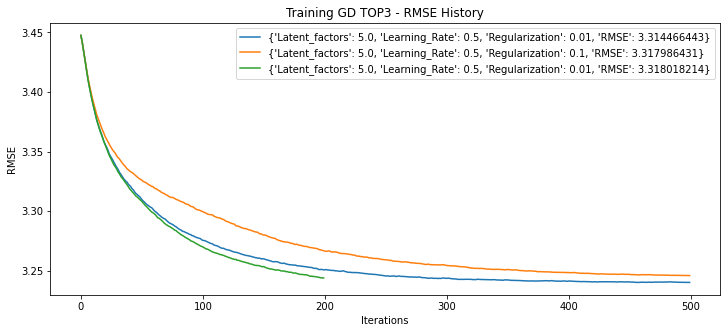

In [138]:
lines = results.History.values
lines = lines[nSmallestIdx]
lines= [eval(l) for l in lines]
# print(lines)
plt.figure(figsize=(12,5))

for l in lines:
    plt.plot(l)


leg = (results.loc[nSmallestIdx,['Latent_factors','Learning_Rate','Regularization','RMSE']]).T.to_dict().values()
# plt.xticks(np.arange(n_iterations[0]+1))
plt.title('Training GD TOP3 - RMSE History')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.legend(leg)
plt.show();

In [139]:
# RMSE is important but we can also use other metrics we can use to evaluate the model
# here we gave RMSE a weight of 10 and all other metrics a weight of 1
results["RMSERank"] = results["RMSEFloat"].rank(method='dense',ascending=False, pct= True) * 10
results["MRR_5Rank"] = results["MRR_5"].rank(method='dense',ascending=True, pct= True)
results["MRR_10Rank"] = results["MRR_10"].rank(method='dense',ascending=True, pct= True)
results["NDCG_5Rank"] = results["NDCG_5"].rank(method='dense',ascending=True, pct= True)
results["NDCG_10Rank"] = results["NDCG_10"].rank(method='dense',ascending=True, pct= True)
results["Rank"] = results[["RMSERank","MRR_5Rank","MRR_10Rank","NDCG_5Rank","NDCG_10Rank"]].mean(axis=1)
results["Method"]= "MF HypParSearch"
results.sort_values(by='Rank',ascending=False).head(3)

,Latent_factors,Iterations,Learning_Rate,Regularization,BatchSize,Convergence,RMSE,MRR_5,MRR_10,NDCG_5,...,Time,IterPerformed,RMSEFloat,RMSERank,MRR_5Rank,MRR_10Rank,NDCG_5Rank,NDCG_10Rank,Rank,Method
40,5,200,0.5,0.01,20,0.001,3.318018,0.056186,0.065246,0.028864,...,764.862868,200,3.318018,9.789474,0.650602,0.666667,0.2625,0.285714,2.330991,MF HypParSearch
5,10,200,0.5,0.01,100,0.001,3.330962,0.080718,0.088748,0.041494,...,835.684911,200,3.330962,8.842105,0.734940,0.763441,0.6000,0.461538,2.280405,MF HypParSearch
23,20,200,0.5,0.01,100,0.001,3.334987,0.082344,0.091727,0.044157,...,787.430875,200,3.334987,8.631579,0.746988,0.774194,0.6125,0.604396,2.273931,MF HypParSearch



**Q: is there a clear winner?**  

In [140]:
# The 3 best performing parameters set in RMSE terms showed similar results (+/- 0.5 %) in all evaluation measures
bestIdx= results['Rank'].nlargest(1).index
results.iloc[bestIdx,:]

,Latent_factors,Iterations,Learning_Rate,Regularization,BatchSize,Convergence,RMSE,MRR_5,MRR_10,NDCG_5,...,Time,IterPerformed,RMSEFloat,RMSERank,MRR_5Rank,MRR_10Rank,NDCG_5Rank,NDCG_10Rank,Rank,Method
40,5,200,0.5,0.01,20,0.001,3.318018,0.056186,0.065246,0.028864,...,764.862868,200,3.318018,9.789474,0.650602,0.666667,0.2625,0.285714,2.330991,MF HypParSearch


Please add your winner to `final_results` dataframe.

In [141]:
# final_results = pd.DataFrame(columns=final_results.columns)
final_results= final_results.append(results.loc[bestIdx,['Method','Latent_factors','Iterations','Learning_Rate','Regularization','Convergence','RMSE','MRR_5','MRR_10','NDCG_5','NDCG_10','Time']],ignore_index=True)
final_results
# pass

,Method,Time,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10,Latent_factors,Iterations,Learning_Rate,Regularization,Convergence
0,Popularity,0.008003,1.308793,0.700399,0.702474,0.822597,0.856581,NaN,NaN,NaN,NaN,NaN
1,MF HypParSearch,764.862868,3.318018,0.056186,0.065246,0.028864,0.031571,5.0,200.0,0.5,0.01,0.001


In [142]:
#  helper function to plot the results
def plotMetric(df, metric):
    plt.figure(figsize=(15,6))
    metricFormatted= metric.replace("_"," ")
    columns = [metric, 'RMSE','MRR_5','MRR_10','NDCG_5','NDCG_10']
    resultsGrouped = df[columns].groupby([metric]).mean()
    plt.suptitle(f'Metrics evaluation per {metricFormatted}',fontsize=16)
    plt.tight_layout(pad=5.0)
    #  draw sub plots of the metrics
    for i,KPI in enumerate(['RMSE','MRR_5','MRR_10','NDCG_5','NDCG_10']):
        plt.subplot(2,3,i+1)
        plt.plot(resultsGrouped.index,resultsGrouped[KPI])
        plt.title(f'{KPI} ')
        plt.xticks(resultsGrouped.index, rotation=45)
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
    plt.show()

# plotMetric(results,'Latent_factors')


**Understanding The Effect - `Latent Factors` - Your Conclusions:**


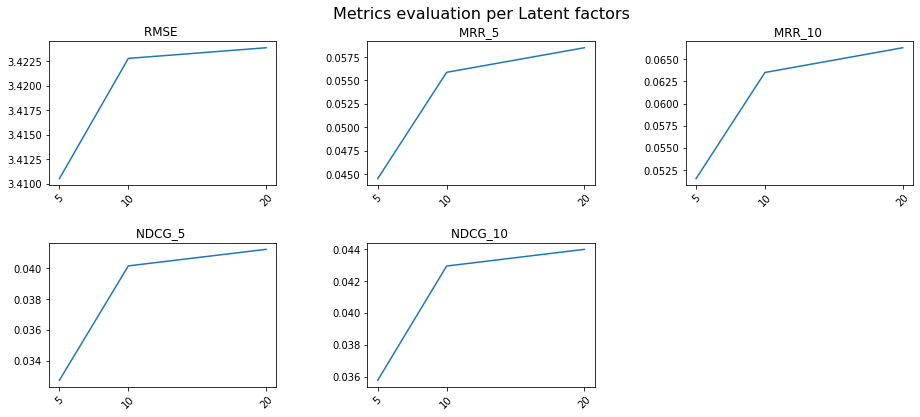

In [143]:
# for the latent factors variable we can conclud that 20 produce best results across all evaluation metrics except for RMSE, which has best results at 5 latent factors
#  this insinuates that the information captured within the data is best represented by 20 latent factors for the top recommendations, but when looking at the
#  overall RMSE, the model is better at predicting the ratings for the 5 latent factors
plotMetric(results,'Latent_factors')


**Understanding The Effect - `Learning Rate` - Your Conclusions:**


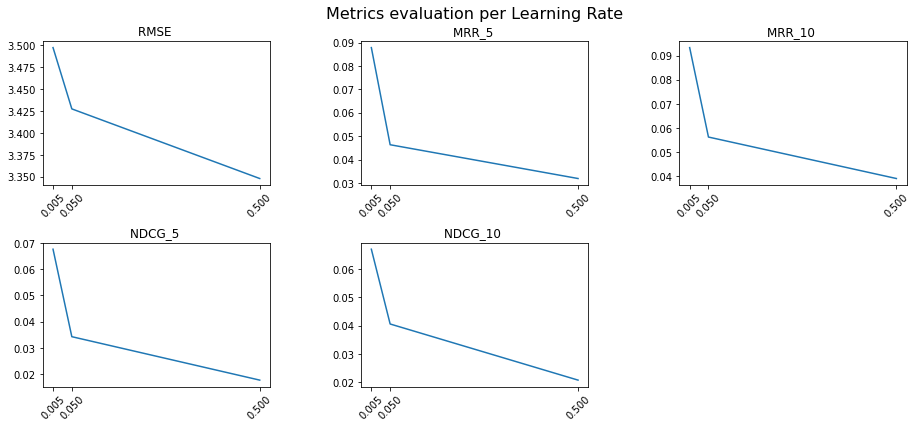

In [144]:
#  we used an adaptive learning rate where we start with a high learning rate and decrease it as the iterations progress exponentially
#  we can see that the best RMSE results are achieved with a learing rate which starts at 0.5 and decreasing exponentially.
plotMetric(results,'Learning_Rate')

**Understanding The Effect - `Regularization` - Your Conclusions:**

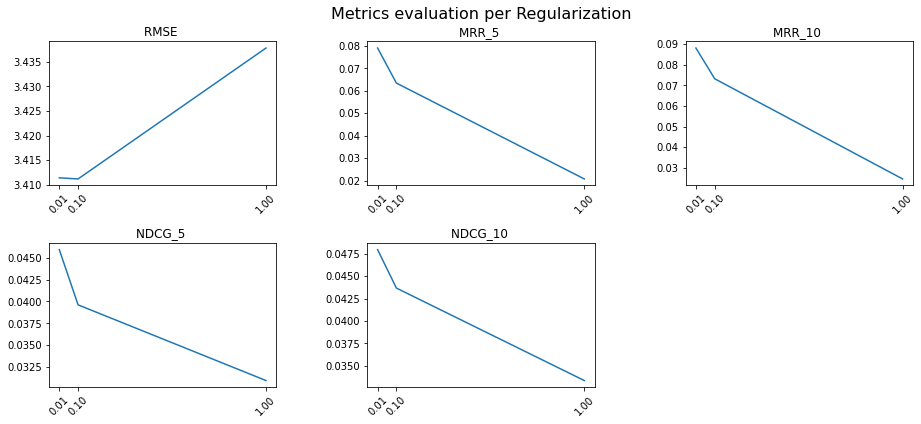

In [145]:
# all metrics agree that regularization of 0.01 produces the best results
plotMetric(results,'Regularization')

<br><br><br>

## D. Bias only based model
#### Repeat the explicit matrix factorization implementation for the bias only model. Please use the same visualizations.  

<br>

**Hyperparams search + train the model :**

In [146]:
n_iterations   = [70] # just one value due to computational power
convergence    = [1e-5,1e-3]  
latent_factors = [5, 10, 20]
regularization = [0.01, 0.1, 1]
learning_rate  = [0.005, 0.05, 0.3]
batch_size     = [200]
DFFileName= 'BOresults'
# number of experiments:
if type(isDFThere(DFFileName)) == pd.core.frame.DataFrame:
    resultsBO = isDFThere(DFFileName)
else:
    i=0
    resultsBO = pd.DataFrame(columns=['Latent_factors','Iterations','Learning_Rate','Regularization','Convergence','RMSE','MRR_5','MRR_10','NDCG_5','NDCG_10','History','Time'])

    for n_iter in n_iterations:
        for lf in latent_factors:
            for lr in learning_rate:
                for reg in regularization:
                    for conv in convergence:
                        for bs in batch_size:
                            dic = {'Iterations':n_iter,'Latent_factors':lf,'Learning_Rate':lr,'Regularization':reg,'BatchSize':bs,'Convergence':conv}

                        # initialize model
                        biasOnly = MF(train.values,n_factors=lf, only_bias=True)
                        
                        # record training time
                        start = time.time()
                        
                        # train MF
                        biasOnly.fit(n_iterations=n_iter,verbose=False,learning_rate=lr,regularization=reg,convergence=conv, batch_size=bs)
                        dic['Time'] = time.time() - start
                        
                        # eval model
                        # please use the model evaluation funcntions 
                        dic["RMSE"]    = biasOnly.get_rmse(test.values)
                        dic["MRR_5"]   = biasOnly.get_mrr(test.values,k=5)
                        dic["MRR_10"]  = biasOnly.get_mrr(test.values,k=10)
                        dic["NDCG_5"]  = biasOnly.get_ndcg(test.values,k=5)
                        dic["NDCG_10"] = biasOnly.get_ndcg(test.values,k=10)
                        i+=1
                        print(f'Done with {i}/{n_experiments} experiments, RMSE {dic["RMSE"]} batch size {bs} latent factors {lf} learning rate {lr} regularization {reg} convergence {conv} iterations performed {len(biasOnly.history)}')
                        # record model history
                        dic['History'] = biasOnly.history # model 
                        
                        # add experiment
                        resultsBO = resultsBO.append(dic,ignore_index=True)
                        resultsBO.to_csv(f'{DFFileName}.csv',index=False)
resultsBO.head(5)

found BOresults at path : True
found BOresults at path : True


,Latent_factors,Iterations,Learning_Rate,Regularization,Convergence,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10,History,Time,BatchSize
0,5,70,0.005,0.01,0.00001,3.506547,0.0,0.0,0.077244,0.075781,"[3.4463906250339527, 3.4463531657256006, 3.446...",248.401899,200.0
1,5,70,0.005,0.01,0.00100,3.506560,0.0,0.0,0.077244,0.075781,"[3.4463906250339527, 3.4463547137639923, 3.446...",257.924188,200.0
2,5,70,0.005,0.10,0.00001,3.506530,0.0,0.0,0.077244,0.075781,"[3.4463906250339527, 3.4463547343102867, 3.446...",251.833846,200.0
3,5,70,0.005,0.10,0.00100,3.506531,0.0,0.0,0.077261,0.075763,"[3.4463906250339527, 3.4463539923580444, 3.446...",255.816679,200.0
4,5,70,0.005,1.00,0.00001,3.506445,0.0,0.0,0.073947,0.072802,"[3.4463906250339527, 3.4463565270331293, 3.446...",249.014211,200.0


**Choose your top3 models:**


In [147]:
results= resultsBO.copy()
results['RMSEFloat'] = results['RMSE'].astype(float)
nSmallestIdx= results['RMSEFloat'].nsmallest(3).index
results.loc[nSmallestIdx,:]

,Latent_factors,Iterations,Learning_Rate,Regularization,Convergence,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10,History,Time,BatchSize,RMSEFloat
49,20,70,0.3,0.01,0.00100,3.386692,0.051113,0.062290,0.034130,0.041543,"[3.4463906250339527, 3.4437239800483552, 3.440...",239.935028,200.0,3.386692
12,5,70,0.3,0.01,0.00001,3.386736,0.051113,0.059500,0.034130,0.036651,"[3.4463906250339527, 3.443431556556945, 3.4401...",223.610627,200.0,3.386736
31,10,70,0.3,0.01,0.00100,3.386762,0.050318,0.061343,0.033874,0.041370,"[3.4463906250339527, 3.443810327314897, 3.4402...",235.196186,200.0,3.386762


**Add your winner to `final_resuls` dataframe:**

In [148]:
# RMSE is important but we can also use other metrics we can use to evaluate the model
# here we gave RMSE a weight of 10 and all other metrics a weight of 1
results["RMSERank"] = results["RMSEFloat"].rank(method='dense',ascending=False, pct= True) * 10
results["MRR_5Rank"] = results["MRR_5"].rank(method='dense',ascending=True, pct= True)
results["MRR_10Rank"] = results["MRR_10"].rank(method='dense',ascending=True, pct= True)
results["NDCG_5Rank"] = results["NDCG_5"].rank(method='dense',ascending=True, pct= True)
results["NDCG_10Rank"] = results["NDCG_10"].rank(method='dense',ascending=True, pct= True)
results["Rank"] = results[["RMSERank","MRR_5Rank","MRR_10Rank","NDCG_5Rank","NDCG_10Rank"]].mean(axis=1)
results["Method"]= "Bias Only HypParSearch"
results.sort_values(by='Rank',ascending=False).head(3)

,Latent_factors,Iterations,Learning_Rate,Regularization,Convergence,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10,...,Time,BatchSize,RMSEFloat,RMSERank,MRR_5Rank,MRR_10Rank,NDCG_5Rank,NDCG_10Rank,Rank,Method
49,20,70,0.3,0.01,0.00100,3.386692,0.051113,0.06229,0.034130,0.041543,...,239.935028,200.0,3.386692,10.000000,0.619048,0.611111,0.357143,0.315789,2.380618,Bias Only HypParSearch
48,20,70,0.3,0.01,0.00001,3.386793,0.051962,0.06330,0.033252,0.041860,...,238.166653,200.0,3.386793,9.444444,0.666667,0.666667,0.214286,0.368421,2.272097,Bias Only HypParSearch
12,5,70,0.3,0.01,0.00001,3.386736,0.051113,0.05950,0.034130,0.036651,...,223.610627,200.0,3.386736,9.814815,0.619048,0.388889,0.357143,0.131579,2.262295,Bias Only HypParSearch


In [149]:
bestIdx= results['Rank'].nlargest(1).index
results.iloc[bestIdx,:]
final_results= final_results.append(results.loc[bestIdx,['Method','Latent_factors','Iterations','Learning_Rate','Regularization','Convergence','RMSE','MRR_5','MRR_10','NDCG_5','NDCG_10','Time']],ignore_index=True)
final_results

,Method,Time,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10,Latent_factors,Iterations,Learning_Rate,Regularization,Convergence
0,Popularity,0.008003,1.308793,0.700399,0.702474,0.822597,0.856581,NaN,NaN,NaN,NaN,NaN
1,MF HypParSearch,764.862868,3.318018,0.056186,0.065246,0.028864,0.031571,5.0,200.0,0.5,0.01,0.001
2,Bias Only HypParSearch,239.935028,3.386692,0.051113,0.062290,0.034130,0.041543,20.0,70.0,0.3,0.01,0.001


<br><br>
**Different Methods - Conclude Final Results**

In [150]:
final_results

,Method,Time,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10,Latent_factors,Iterations,Learning_Rate,Regularization,Convergence
0,Popularity,0.008003,1.308793,0.700399,0.702474,0.822597,0.856581,NaN,NaN,NaN,NaN,NaN
1,MF HypParSearch,764.862868,3.318018,0.056186,0.065246,0.028864,0.031571,5.0,200.0,0.5,0.01,0.001
2,Bias Only HypParSearch,239.935028,3.386692,0.051113,0.062290,0.034130,0.041543,20.0,70.0,0.3,0.01,0.001


**Understand `only-Bias-model` VS `full-model` - Your Conclusions:**  
- In "only-Bias-model", we only learn the bias parameters so we end up with a model that is more general, and it doesn't learn:
1. user @ item interactions- which can help to understand users' preferences in lower resolution
2. latent features within items 
   
Since less parameters ae required, the "only-Bias-model" is faster to learn.
The "only-Bias-model" can be more efficient on a real world problem which is of extreamly biased nature, as user @ item intersection hold little information.
The "only-Bias-model" can be used as a banch-mark to evaluate full MF contribution. If full MF contribution is low, we could be looking at a very biased reality, or a bad MF model.

## E. Discussion 

Describe your challenges and findings, including comparison between the algorithms as well as your recommendations for how to select the latent factor dimension, the contribution of regularization and pros\cons of the different algorithms.

In your comparison refer to the evaluation metrics, training and inference duration, learning convergence and additional aspects you find relevant.

### Challenges
Our main challenge in this implementation was the performance and time it took the algorithm to learn. Steps we took to improve learning time:
1. *Decaying learning time* - we have found that starting with a high learning rate, and exponentially decaying it allow for faster learning at first, without loosing the ability to converge.
2. *2 level parameter search*- we started by searching hyper parameters at 200 interations, and then extended to 500 iteration on improved hyper parameter selection.


### Algorith performance comparison by metrics
The results provided by our models have been very surprising. 
Method | Time| RMSE | MRR5 | MRR10 | NDCG_5 | NDCG_10
---|---|--|--|--|--|--
Popularity | 0.009 | 2.62 | 0.053 | 0.066| 0.034 | 0.038
MF  |	764	|3.318	|0.056	|0.065	|0.0288	|0.0315
Bias Only |	239.935028	|3.386692	|0.051113	|0.062290	|0.034130	|0.041543

We would like to describe the expected result, and then try and explain the results we have gotten, assuming these are valid.
#### Learning Time
No surprises here. Learning time for the popularity model is minimal as it performs all calculations once only. The learning of the other models took roughly 4 seconds per itteration, and seems to correspond mainly to the batch size of the gradient descent.


#### RMSE
The expected result for RMSE was that a full MF model would provide the best result, followed by a bias only model, and the popularity model to produce the worst result. The reason for that would be that the most “personalized” prediction would be given by a full MF model, which considers the user and item intersection with detailed bias, followed by the bias-only model, which considers biases of users and items only.
In our experiment the popularity model has given a surprisingly low RMSE in comparison to the other models. Another surprising result is that the bias-only model has consistently produced better results than the full MF model, leading us to believe we have a problem in the implementation.

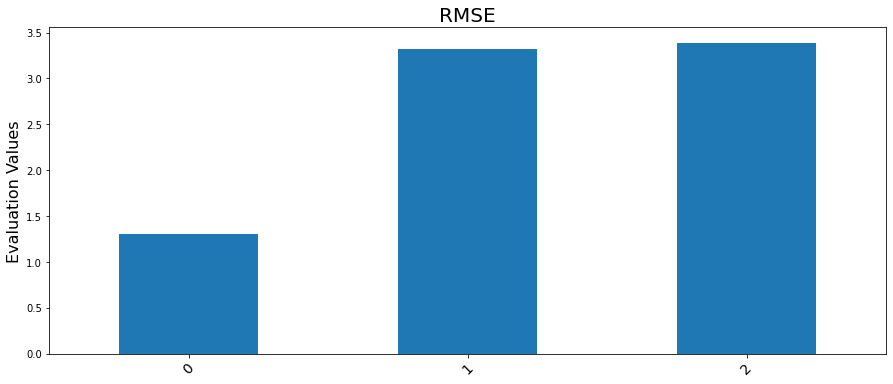

In [151]:
# final_results = final_results.set_index('Method')
final_results['Time_Ratio'] = final_results['Time']/final_results['Time'].max()

final_results.loc[::,('RMSE')].T.plot(kind="bar", figsize=(15,6))
plt.title("RMSE", fontsize=20)
# plt.xlabel("Evaluation Methods", fontsize=16)
plt.ylabel("Evaluation Values", fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.show();

#### MRR and NDCG
The expected results for the MRR metrics was that MRR would be higher for the full MF model, as it captures user tase towards specific items, followed by the bias only model, as it captures user bias towards all items and item bias for all users, with the popularity model coming in last with successful predictions made only for users with taste for the popular items.
The results we have gotten in our experiments appear to be inconsistent and contradict our initial expectation. In any case, the results of MRR do not appear to be convincing that any algorithm provides significant improvements over the others, which leads us to believe our implementation is incorrect.
Method | MRR5 | MRR10 
---|---|--
Popularity  | 0.053 | 0.066
MF  	|0.056	|0.065
Bias Only 	|0.0511	|0.0622

The expected result for NDCG, as with the rest of the metrics, is that a full MF model would out perform a bias-only model which is expected to out perform a popularity model.
The results we have seen in our experiment suggest a poularity model out performed the MF model, and matched the bias-only model on NDCG5. 
Method | NDCG_5 | NDCG_10
---|---|--
Popularity | 0.034 | 0.038
MF  	|0.0288	|0.0315
Bias Only	|0.034	|0.0415



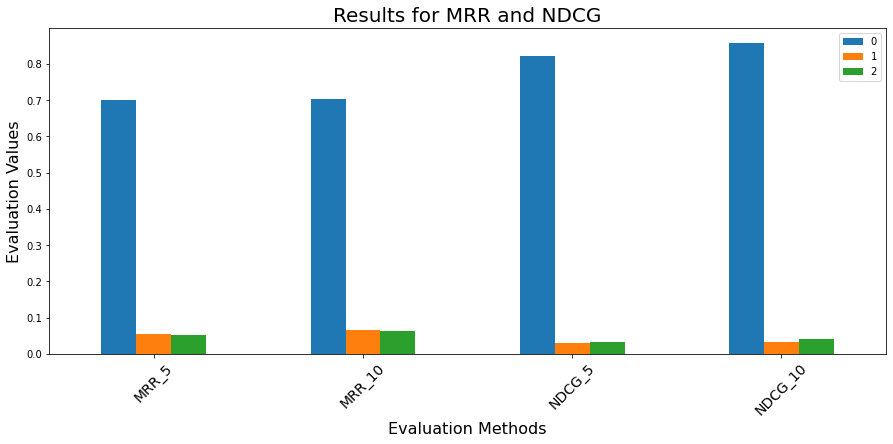

,Method,Time,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10,Latent_factors,Iterations,Learning_Rate,Regularization,Convergence,Time_Ratio
0,Popularity,0.008003,1.308793,0.700399,0.702474,0.822597,0.856581,NaN,NaN,NaN,NaN,NaN,0.000010
1,MF HypParSearch,764.862868,3.318018,0.056186,0.065246,0.028864,0.031571,5.0,200.0,0.5,0.01,0.001,1.000000
2,Bias Only HypParSearch,239.935028,3.386692,0.051113,0.062290,0.034130,0.041543,20.0,70.0,0.3,0.01,0.001,0.313697


In [152]:
# final_results = final_results.set_index('Method')
final_results['Time_Ratio'] = final_results['Time']/final_results['Time'].max()

final_results.loc[::,('MRR_5','MRR_10','NDCG_5','NDCG_10')].T.plot(kind="bar", figsize=(15,6))
plt.title("Results for MRR and NDCG", fontsize=20)
plt.xlabel("Evaluation Methods", fontsize=16)
plt.ylabel("Evaluation Values", fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.show();

final_results

### Model parameters effect on performance
#### Number of latent dimensions and Regularization 
The expected result of the effect of the number of latent dimensions in the models is that the more dimensions we add, the more performant the model gets, up to a point where we overfit.
The point of overfit is where the model gets too complex to generalize the data of the test (or the reality). Another counter effective consideration is that the number of latent dimensions also adds computational effort.

The overfitting often observed with models with high complexity can often be controlled with the introduction of proper regularization. Regularization allows for some flexability during learning, with proper regularization rates leading to optimal results on real world diverse data.

#### Learning rate, time and Convergence
High learning rate can allow for a faster learning time, but can also cause the model to overshoot the optimum, causing the model to miss the convergence. For this consideration, we have chosen a decaying learning rate, which starts high and later decays exponentially, hoping for a quicker convergence. It appears that due to some problem with our implementation, we have not reached convergence with any learning rate and number of iterations we have tried (up to 1000 iterations).



`popularity bias:` 
for the popularity model, we have gotten results which seem to be logic in the sense that these are movies which are very popular, and probably reflect the mose popular for the american audience in 1995.
167           Private Benjamin (1980)
316         As Good As It Gets (1997)
481             Apartment, The (1960)
62                    Stargate (1994)
10                 Richard III (1995)
48                 Hoop Dreams (1994)
601    For Whom the Bell Tolls (1943)
112                    Flipper (1996)
511         Lawrence of Arabia (1962)
176                     Aliens (1986)

`item cold-start problem:`
Our recommendations are based on user and item onteractions. When adding new items, we have a challenge as we don't have and rating history for it. 
One possible solution can be using the ratings of other items with similar attributes (genres, lengths, cast). Values of similar items can be merged into a new item vector to be added into the item_vectors, reflecting the new item's inferred attributes.

`scalability issue:` - Our rating matrix has as many lines as user and as many columns as items. This is not scalable to real life as during training we have to hold data structures of User * Item size in memory. Things are improving once the model is learned, as we only have to consider the factored data structures- the User and item matrixes, which are scalable.

`MRR VS nDCG`

**MRR**  
`Pros:`   
    -   MRR may be a good metric to use if the goal of the recommendation system is to rank the recommended items in order of relevance, and the user is interested in the average ranking of the recommended items. 

`Cons:`    
    -   since we only measure the performance of the the top K, we could be loosing information as to how diverse the recommendation is on the items that follow the first K.

**NDCG**  
`Pros:`  
    -   NDCG can be a good metric to use if the goal of the recommendation system is to recommend a set of items that will provide the user with the maximum cumulative gain. in this case, NDCG can provide a good measure of the overall value of the recommended items to the user, without penelizing the order of the first K items returned Vs. the ground truth.

`Cons:`  
    -   it is more influenced by irrelevant items, especially if presented in low ranks.


# Question 4: 


## Item similarity & explainability 
a)	Suggest a method to find similarity between items. Demonstrate the approach on a set of 5 item pairs of your choice based on item representation by your best matrix factorization model. Leverage the items side information available in the dataset to demonstrate the effectiveness of the suggested approach. 

b)	Select two latent dimensions of your matrix factorization model and try to estimate the latent ‘meaning’ of the learnt matrix factorization model. Demonstrate your estimation, using few items from the dataset and the items side information available in the dataset and\or external information. find the most frequent genre/ features of the items 


In [153]:
# create MF model
model_mfF = MF(train.values,n_factors=10,only_bias=False)

# train model
%time model_mfF.fit(n_iterations=200,verbose=False, learning_rate=0.01, regularization=0.01, convergence=1e-05, initialize_training=True)

KeyboardInterrupt: 

**Known methods to find similarity between items are:**
- Pearson Corellation  
- Cosine Similarity 
- Mean Difference
- L2 Distance

**Please implement them using numpy package:** 
(for example: np.linalg)


### Similarity between pairs

In [ ]:
def get_item2vec(mf,i):
    return mf.item_vectors[i-1]

def get_pearson_similarity(a,b):
    a = a - np.mean(a)
    b = b - np.mean(b)
    return np.sum(a*b) / np.sqrt(np.sum(a*a) * np.sum(b*b))

def get_cosine_similarity(a,b):
    return np.sum(a*b) / np.sqrt(np.sum(a*a) * np.sum(b*b))


def get_mean_diff_similarity(a1,a2):
    return np.abs(np.mean(a1)- np.mean(a2))

def get_l2_similarity(a1,a2):
    return np.sqrt(np.sum((a1-a2)**2))




In [ ]:
#  helper function to print triplets
def getSimilarity(mf, items, similarity_func):
    item_vectors = [get_item2vec(mf,item) for item in items]
    return similarity_func(item_vectors[0],item_vectors[1]), df_items.iloc[items]



In [ ]:
# items 1 and 2 GoldenEye (1995) and Four Rooms (1995)	
# both movies are thrillers, but one has also action and advanture genres
similarity= getSimilarity(model_mfF,[1,2],get_l2_similarity)
print(f'Similarity score is {round(similarity[0],3)}')
similarity[1].head()

Similarity score is 0.299


,movie id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Childrens,...,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
# 49		Star Wars (1977), 171	Empire Strikes Back, The (1980)
#  very similar movies in terms of genres, expecting user ratings to be very similar
similarity= getSimilarity(model_mfF,[49,171],get_l2_similarity)
print(f'Similarity score is {round(similarity[0],3)}')
similarity[1].head()

Similarity score is 0.387


,movie id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Childrens,...,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western
49,50,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,0,1,1,0,0,...,0,0,0,0,0,1,1,0,1,0
171,172,"Empire Strikes Back, The (1980)",01-Jan-1980,NaN,http://us.imdb.com/M/title-exact?Empire%20Stri...,0,1,1,0,0,...,0,0,0,0,0,1,1,0,1,0


In [ ]:
# 10		Seven (Se7en) (1995), 11		Usual Suspects, The (1995)
similarity= getSimilarity(model_mfF,[10,11],get_l2_similarity)
print(f'Similarity score is {similarity[0]}')
similarity[1].head()

Similarity score is 0.34571936958292343


,movie id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Childrens,...,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western
10,11,Seven (Se7en) (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Se7en%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
11,12,"Usual Suspects, The (1995)",14-Aug-1995,NaN,http://us.imdb.com/M/title-exact?Usual%20Suspe...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
# 221		Star Trek: First Contact (1996), 171	Empire Strikes Back, The (1980)
similarity= getSimilarity(model_mfF,[221,171],get_l2_similarity)
print(f'Similarity score is {similarity[0]}')
similarity[1].head()

Similarity score is 0.25634159160555525


,movie id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Childrens,...,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western
221,222,Star Trek: First Contact (1996),22-Nov-1996,NaN,http://us.imdb.com/M/title-exact?Star%20Trek:%...,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,0
171,172,"Empire Strikes Back, The (1980)",01-Jan-1980,NaN,http://us.imdb.com/M/title-exact?Empire%20Stri...,0,1,1,0,0,...,0,0,0,0,0,1,1,0,1,0


In [ ]:
# 16 From Dusk Till Dawn, 19	Angels and Insects (1995)
similarity= getSimilarity(model_mfF,[16,19],get_l2_similarity)
print(f'Similarity score is {similarity[0]}')
similarity[1].head()

Similarity score is 0.40828679613208285


,movie id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Childrens,...,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western
16,17,From Dusk Till Dawn (1996),05-Feb-1996,NaN,http://us.imdb.com/M/title-exact?From%20Dusk%2...,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
19,20,Angels and Insects (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Angels%20and%...,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


**For the next step, please choose your favorite method.**  

**Please compare 3 triplets of movies, and for each triplet create this:**   
Create a dataframe same as the example

In [ ]:
#  helper function to print triplets
def getSimilarityMatrix(mf, items, similarity_func):
    item_vectors = [get_item2vec(mf,item) for item in items]
    cols= [df_items.set_index('movie id').loc[item]['movie_title'] for item in items]
    item_similarity = np.zeros((len(items),len(items)))
    for i in range(len(items)):
        for j in range(len(items)):
            if i == j:
                item_similarity[i,j] = 1
            else:
                item_similarity[i,j] = similarity_func(item_vectors[i],item_vectors[j])
    return pd.DataFrame(item_similarity, columns=cols, index=cols)

**First Triplet:**

In [ ]:
# 316         As Good As It Gets (1997), 481             Apartment, The (1960), 62                    Stargate (1994)
getSimilarityMatrix(model_mfF, [316,481,62], get_cosine_similarity).head()


,As Good As It Gets (1997),"Apartment, The (1960)",Stargate (1994)
As Good As It Gets (1997),1.000000,0.049873,-0.043964
"Apartment, The (1960)",0.049873,1.000000,0.591780
Stargate (1994),-0.043964,0.591780,1.000000


**Second Triplet:**

In [ ]:
# 112                    Flipper (1996) 511         Lawrence of Arabia (1962) 176                     Aliens (1986)
getSimilarityMatrix(model_mfF, [112,511,176], get_cosine_similarity).head()

,Flipper (1996),Lawrence of Arabia (1962),Aliens (1986)
Flipper (1996),1.000000,-0.145783,0.289711
Lawrence of Arabia (1962),-0.145783,1.000000,-0.200434
Aliens (1986),0.289711,-0.200434,1.000000


**Third Triplet**

In [ ]:
#  222	Star Trek: First Contact (1996) 227	Star Trek VI: The Undiscovered Country (1991) 229 Star Trek III: The Search for Spock (1984)	
getSimilarityMatrix(model_mfF, [222,227,229], get_cosine_similarity).head()

,Sling Blade (1996),Star Trek: The Wrath of Khan (1982),Star Trek IV: The Voyage Home (1986)
Sling Blade (1996),1.000000,-0.292377,-0.297967
Star Trek: The Wrath of Khan (1982),-0.292377,1.000000,0.495907
Star Trek IV: The Voyage Home (1986),-0.297967,0.495907,1.000000


<br><br><br>
**Find two latent dimensions of your matrix factorization model and try to estimate the latent ‘meaning’ of the learnt matrix factorization model.**

**Tip:**  
would we get a good seperation for different genres?  
For example, here we can see that this is not a good seperation.




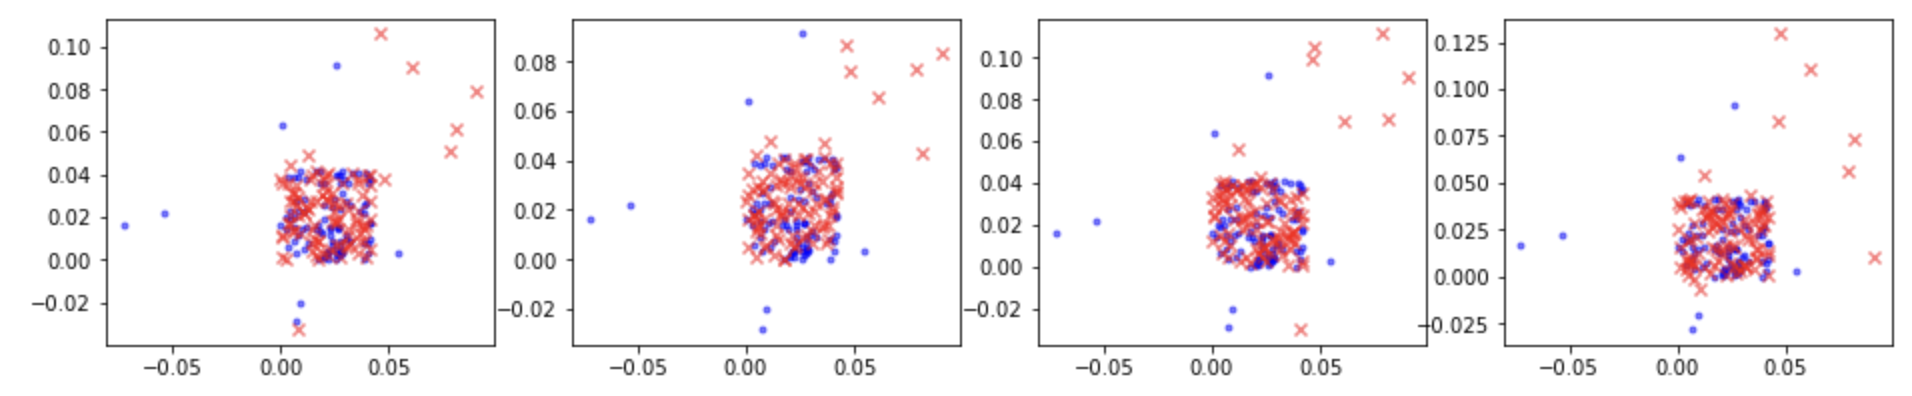

In [ ]:
# merge df_items and item_vectors 
item_vector_cols= [f'item_vector_{i}' for i in range(model_mfF.item_vectors.shape[1])]
genreColums = ['Action', 'Adventure', 'Animation', 'Childrens',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film_Noir',
       'Horror', 'Musical', 'Mystery', 'Romance', 'Sci_Fi', 'Thriller', 'War',
       'Western']
df_item_vectors = pd.DataFrame(model_mfF.item_vectors, columns=item_vector_cols)
df_item_latent = pd.concat([df_items, df_item_vectors], axis=1)
df_item_latent.head(5)

,movie id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Childrens,...,item_vector_0,item_vector_1,item_vector_2,item_vector_3,item_vector_4,item_vector_5,item_vector_6,item_vector_7,item_vector_8,item_vector_9
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,-0.015237,0.150791,-0.057457,0.021174,-0.006182,0.003086,0.116359,-0.098469,0.064973,0.098661
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,-0.075559,0.091029,-0.028560,0.033203,-0.021249,0.105191,0.103218,0.148891,0.105864,0.012693
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,-0.048686,0.002738,0.053235,-0.155845,0.030077,-0.128038,0.091971,0.086405,-0.104133,-0.089829
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0.052296,0.076744,0.189670,0.088398,-0.068634,0.078002,0.149576,0.110706,0.129266,-0.095696
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0.011782,-0.032876,-0.017341,0.156653,0.029654,0.040355,-0.080489,-0.173418,-0.162358,0.163797


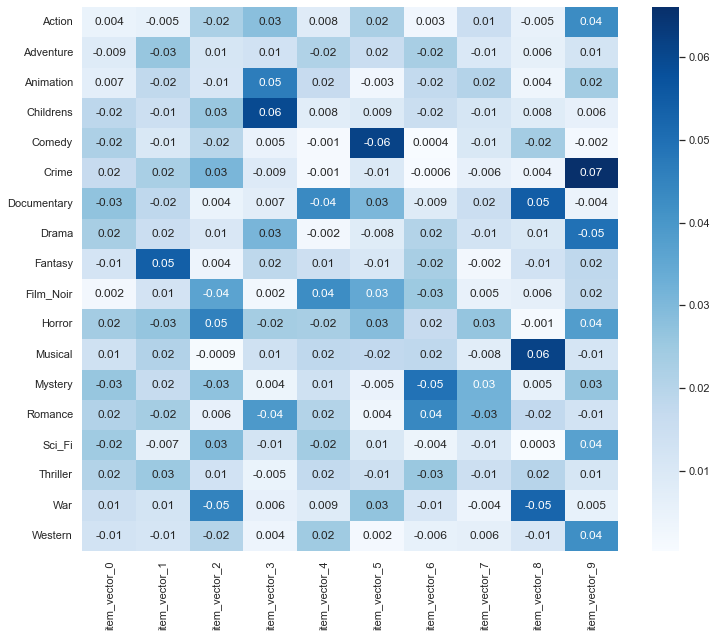

In [ ]:
#  Visualize correlation betwene genres and latent factors
#  absolute values are used to visualize negative correlation
import seaborn as sns
sns.set(rc={'figure.figsize':(12,10)})
df_2by10= df_item_latent[genreColums + item_vector_cols[::]]
df_2by10Corr= df_2by10.corr()[item_vector_cols[::]].loc[genreColums]
heatmap = sns.heatmap(df_2by10Corr.abs(), annot=np.array(df_2by10Corr), cmap="Blues", fmt='.1g')

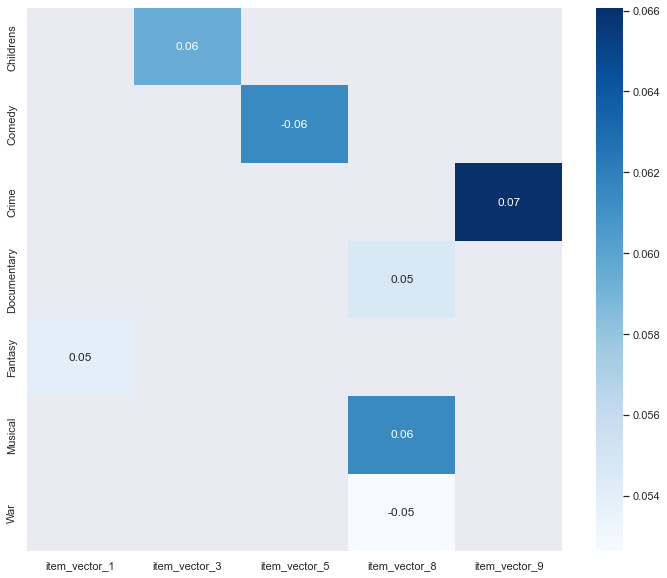

In [ ]:
# keep values which are greater than threshold
threshold= 0.05
df_HighestCorr= df_2by10Corr[df_2by10Corr.abs() > threshold]
#  drop columns and rows with all NaNs
df_HighestCorr= df_HighestCorr.dropna(axis=0, how='all')
df_HighestCorr= df_HighestCorr.dropna(axis=1, how='all')
heatmap = sns.heatmap(df_HighestCorr.abs(), annot=np.array(df_HighestCorr), cmap="Blues", fmt='.1g')

### meaning of latent factors
Seems like item vector 8 is correlated to musicals and documentries, and is invertedly predicting war movies.
Vector 9 seems to be corelated to crime